In [6]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


In [7]:
# Cell 2: Load Data
# Update these paths to your actual file locations
a1 = pd.read_excel(r"C:\Users\kaushal kishor\Desktop\AI_ML\Credit_risk_modelling\case_study1.xlsx")
a2 = pd.read_excel(r"C:\Users\kaushal kishor\Desktop\AI_ML\Credit_risk_modelling\case_study2.xlsx")

df1 = a1.copy()
df2 = a2.copy()

print(f"Dataset 1 shape: {df1.shape}")
print(f"Dataset 2 shape: {df2.shape}")

Dataset 1 shape: (51336, 26)
Dataset 2 shape: (51336, 62)


In [8]:
# Cell 3: Initial Data Cleaning (Basic preprocessing only)
# Remove rows where Age_Oldest_TL is -99999
df1 = df1.loc[df1['Age_Oldest_TL'] != -99999].copy()

# Identify columns with too many missing values in df2
columns_to_be_removed = []
for col in df2.columns:
    if (df2[col] == -99999).sum() > 10000:
        columns_to_be_removed.append(col)

print(f"Removing {len(columns_to_be_removed)} columns with excessive missing values")
df2 = df2.drop(columns_to_be_removed, axis=1)

# Replace -99999 with NaN for proper handling
for col in df2.columns:
    df2.loc[df2[col] == -99999, col] = np.nan

# Drop rows with any NaN values
df2 = df2.dropna()

print(f"After cleaning - Dataset 1 shape: {df1.shape}")
print(f"After cleaning - Dataset 2 shape: {df2.shape}")

Removing 8 columns with excessive missing values
After cleaning - Dataset 1 shape: (51296, 26)
After cleaning - Dataset 2 shape: (42066, 54)


In [9]:
# Cell 4: Merge Datasets
# Check common columns
common_cols = [col for col in df1.columns if col in df2.columns]
print(f"Common columns: {common_cols}")

# Merge the dataframes
df = pd.merge(df1, df2, how='inner', on=['PROSPECTID'])

print(f"Merged dataset shape: {df.shape}")
print(f"\nTarget distribution:\n{df['Approved_Flag'].value_counts()}")

Common columns: ['PROSPECTID']
Merged dataset shape: (42064, 79)

Target distribution:
Approved_Flag
P2    25452
P3     6440
P4     5264
P1     4908
Name: count, dtype: int64


In [10]:
# Cell 5: CRITICAL - Split Data BEFORE Any Feature Selection
# This prevents data leakage

# Separate features and target
X = df.drop(['Approved_Flag', 'PROSPECTID'], axis=1)
y = df['Approved_Flag']

# Split into train and test (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining target distribution:\n{y_train.value_counts()}")

Training set size: (33651, 77)
Test set size: (8413, 77)

Training target distribution:
Approved_Flag
P2    20362
P3     5152
P4     4211
P1     3926
Name: count, dtype: int64


In [11]:
# Cell 6: Feature Selection - Categorical Features (Chi-Square Test)
# ONLY use training data for feature selection

categorical_features = ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']
selected_categorical = []

print("\nChi-Square Test Results:")
print("-" * 50)

for feature in categorical_features:
    if feature in X_train.columns:
        # Create contingency table using ONLY training data
        train_df = pd.concat([X_train[feature], y_train], axis=1)
        contingency_table = pd.crosstab(train_df[feature], y_train)
        chi2, pval, _, _ = chi2_contingency(contingency_table)
        
        print(f"{feature}: p-value = {pval:.6f}")
        
        if pval <= 0.05:
            selected_categorical.append(feature)
            
print(f"\nSelected categorical features: {selected_categorical}")


Chi-Square Test Results:
--------------------------------------------------
MARITALSTATUS: p-value = 0.000000
EDUCATION: p-value = 0.000000
GENDER: p-value = 0.000079
last_prod_enq2: p-value = 0.000000
first_prod_enq2: p-value = 0.000000

Selected categorical features: ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']


In [12]:
# Cell 7: Feature Selection - Numerical Features (VIF)
# Identify numerical columns
numerical_features = []
for col in X_train.columns:
    if X_train[col].dtype in ['int64', 'float64'] and col not in categorical_features:
        numerical_features.append(col)

print(f"\nTotal numerical features: {len(numerical_features)}")

# Calculate VIF ONLY on training data
vif_data = X_train[numerical_features].copy()
columns_to_keep = []
column_index = 0

print("\nVIF Calculation:")
print("-" * 50)

for i in range(len(numerical_features)):
    if column_index >= vif_data.shape[1]:
        break
        
    vif_value = variance_inflation_factor(vif_data.values, column_index)
    current_feature = vif_data.columns[column_index]
    
    print(f"{current_feature}: VIF = {vif_value:.2f}")
    
    if vif_value <= 6:
        columns_to_keep.append(current_feature)
        column_index += 1
    else:
        vif_data = vif_data.drop(current_feature, axis=1)
        
print(f"\nFeatures after VIF filtering: {len(columns_to_keep)}")


Total numerical features: 72

VIF Calculation:
--------------------------------------------------
Total_TL: VIF = inf
Tot_Closed_TL: VIF = inf
Tot_Active_TL: VIF = 11.25
Total_TL_opened_L6M: VIF = 8.49
Tot_TL_closed_L6M: VIF = 6.58
pct_tl_open_L6M: VIF = 5.15
pct_tl_closed_L6M: VIF = 2.58
pct_active_tl: VIF = inf
pct_closed_tl: VIF = 1790.06
Total_TL_opened_L12M: VIF = 8.59
Tot_TL_closed_L12M: VIF = 3.87
pct_tl_open_L12M: VIF = 6.08
pct_tl_closed_L12M: VIF = 5.51
Tot_Missed_Pmnt: VIF = 1.97
Auto_TL: VIF = inf
CC_TL: VIF = 4.74
Consumer_TL: VIF = 23.32
Gold_TL: VIF = 30.80
Home_TL: VIF = 4.27
PL_TL: VIF = 3.03
Secured_TL: VIF = 2.97
Unsecured_TL: VIF = 4.39
Other_TL: VIF = 2.18
Age_Oldest_TL: VIF = 4.92
Age_Newest_TL: VIF = 5.15
time_since_recent_payment: VIF = 3.34
num_times_delinquent: VIF = 7.84
max_recent_level_of_deliq: VIF = 5.36
num_deliq_6mts: VIF = inf
num_deliq_12mts: VIF = 7.49
num_deliq_6_12mts: VIF = 1.42
num_times_30p_dpd: VIF = 8.24
num_times_60p_dpd: VIF = 1.62
num_std:

In [13]:
# Cell 8: ANOVA Test for Numerical Features
# Test ONLY on training data

columns_to_keep_numerical = []

print("\nANOVA Test Results:")
print("-" * 50)

for feature in columns_to_keep:
    # Create groups based on training data only
    groups = []
    for category in y_train.unique():
        group_data = X_train.loc[y_train == category, feature].values
        groups.append(group_data)
    
    f_statistic, p_value = f_oneway(*groups)
    
    print(f"{feature}: p-value = {p_value:.6f}")
    
    if p_value <= 0.05:
        columns_to_keep_numerical.append(feature)

print(f"\nFinal numerical features: {len(columns_to_keep_numerical)}")


ANOVA Test Results:
--------------------------------------------------
pct_tl_open_L6M: p-value = 0.000000
pct_tl_closed_L6M: p-value = 0.000000
Tot_TL_closed_L12M: p-value = 0.000000
pct_tl_closed_L12M: p-value = 0.000000
Tot_Missed_Pmnt: p-value = 0.000000
CC_TL: p-value = 0.000000
Home_TL: p-value = 0.000000
PL_TL: p-value = 0.000000
Secured_TL: p-value = 0.000000
Unsecured_TL: p-value = 0.000000
Other_TL: p-value = 0.000000
Age_Oldest_TL: p-value = 0.000000
Age_Newest_TL: p-value = 0.000000
time_since_recent_payment: p-value = 0.000000
max_recent_level_of_deliq: p-value = 0.000000
num_deliq_6_12mts: p-value = 0.000000
num_times_60p_dpd: p-value = 0.000000
num_std_12mts: p-value = 0.000000
num_sub: p-value = 0.000000
num_sub_6mts: p-value = 0.052348
num_sub_12mts: p-value = 0.007366
num_dbt: p-value = 0.000000
num_dbt_12mts: p-value = 0.010791
num_lss: p-value = 0.003657
num_lss_6mts: p-value = 0.206966
num_lss_12mts: p-value = 0.055351
recent_level_of_deliq: p-value = 0.000000
CC_

In [14]:
# Cell 9: Combine Selected Features
final_features = columns_to_keep_numerical + selected_categorical

print(f"\nTotal selected features: {len(final_features)}")
print(f"Numerical: {len(columns_to_keep_numerical)}")
print(f"Categorical: {len(selected_categorical)}")

# Create final training and test sets with selected features
X_train_selected = X_train[final_features].copy()
X_test_selected = X_test[final_features].copy()



Total selected features: 41
Numerical: 36
Categorical: 5


In [15]:
# Cell 10: Encode EDUCATION (Ordinal Feature)
# Apply same encoding to both train and test

education_mapping = {
    'SSC': 1,
    '12TH': 2,
    'GRADUATE': 3,
    'UNDER GRADUATE': 3,
    'POST-GRADUATE': 4,
    'OTHERS': 1,
    'PROFESSIONAL': 3
}

if 'EDUCATION' in X_train_selected.columns:
    X_train_selected['EDUCATION'] = X_train_selected['EDUCATION'].map(education_mapping).astype(int)
    X_test_selected['EDUCATION'] = X_test_selected['EDUCATION'].map(education_mapping).astype(int)
    print("EDUCATION encoded successfully")

EDUCATION encoded successfully


In [16]:
# Cell 11: One-Hot Encode Nominal Categorical Features
nominal_features = [f for f in selected_categorical if f != 'EDUCATION']

X_train_encoded = pd.get_dummies(X_train_selected, columns=nominal_features, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_selected, columns=nominal_features, drop_first=True)

# Ensure train and test have same columns
# Add missing columns to test set
for col in X_train_encoded.columns:
    if col not in X_test_encoded.columns:
        X_test_encoded[col] = 0

# Remove extra columns from test set
X_test_encoded = X_test_encoded[X_train_encoded.columns]

print(f"Final training shape: {X_train_encoded.shape}")
print(f"Final test shape: {X_test_encoded.shape}")

Final training shape: (33651, 49)
Final test shape: (8413, 49)


In [12]:
# Cell 12: Model 1 - Random Forest
print("\n" + "="*60)
print("RANDOM FOREST CLASSIFIER")
print("="*60)

rf_classifier = RandomForestClassifier(
    n_estimators=200, 
    max_depth=15,  # Limit depth to prevent overfitting
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

rf_classifier.fit(X_train_encoded, y_train)
y_pred_rf = rf_classifier.predict(X_test_encoded)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nAccuracy: {accuracy_rf:.4f}")

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_rf, 
                                                                   labels=['P1', 'P2', 'P3', 'P4'])

print("\nPer-Class Metrics:")
print("-" * 50)
for i, category in enumerate(['P1', 'P2', 'P3', 'P4']):
    print(f"Class {category}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1 Score: {f1_score[i]:.4f}")
    print()



RANDOM FOREST CLASSIFIER

Accuracy: 0.7706

Per-Class Metrics:
--------------------------------------------------
Class P1:
  Precision: 0.8697
  Recall: 0.6731
  F1 Score: 0.7589

Class P2:
  Precision: 0.7887
  Recall: 0.9534
  F1 Score: 0.8633

Class P3:
  Precision: 0.4571
  Recall: 0.1739
  F1 Score: 0.2520

Class P4:
  Precision: 0.7376
  Recall: 0.7075
  F1 Score: 0.7222



In [13]:
# Cell 13: Model 2 - XGBoost
print("\n" + "="*60)
print("XGBOOST CLASSIFIER")
print("="*60)

# Encode target labels for XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb_classifier = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    max_depth=6,  # Limit depth
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_classifier.fit(X_train_encoded, y_train_encoded)
y_pred_xgb = xgb_classifier.predict(X_test_encoded)

# Convert predictions back to original labels
y_pred_xgb_labels = label_encoder.inverse_transform(y_pred_xgb)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb_labels)
print(f"\nAccuracy: {accuracy_xgb:.4f}")

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_xgb_labels,
                                                                   labels=['P1', 'P2', 'P3', 'P4'])

print("\nPer-Class Metrics:")
print("-" * 50)
for i, category in enumerate(['P1', 'P2', 'P3', 'P4']):
    print(f"Class {category}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1 Score: {f1_score[i]:.4f}")
    print()


XGBOOST CLASSIFIER

Accuracy: 0.7801

Per-Class Metrics:
--------------------------------------------------
Class P1:
  Precision: 0.8321
  Recall: 0.7719
  F1 Score: 0.8008

Class P2:
  Precision: 0.8202
  Recall: 0.9234
  F1 Score: 0.8688

Class P3:
  Precision: 0.4501
  Recall: 0.2764
  F1 Score: 0.3425

Class P4:
  Precision: 0.7635
  Recall: 0.7113
  F1 Score: 0.7365



In [14]:
# Cell 14: Model 3 - Decision Tree
print("\n" + "="*60)
print("DECISION TREE CLASSIFIER")
print("="*60)

dt_classifier = DecisionTreeClassifier(
    max_depth=10,  # Reduced from 20
    min_samples_split=50,  # Increased from 10
    min_samples_leaf=20,
    random_state=42
)

dt_classifier.fit(X_train_encoded, y_train)
y_pred_dt = dt_classifier.predict(X_test_encoded)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"\nAccuracy: {accuracy_dt:.4f}")

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_dt,
                                                                   labels=['P1', 'P2', 'P3', 'P4'])

print("\nPer-Class Metrics:")
print("-" * 50)
for i, category in enumerate(['P1', 'P2', 'P3', 'P4']):
    print(f"Class {category}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1 Score: {f1_score[i]:.4f}")
    print()


DECISION TREE CLASSIFIER

Accuracy: 0.7576

Per-Class Metrics:
--------------------------------------------------
Class P1:
  Precision: 0.7851
  Recall: 0.7627
  F1 Score: 0.7738

Class P2:
  Precision: 0.8148
  Recall: 0.8961
  F1 Score: 0.8535

Class P3:
  Precision: 0.4022
  Recall: 0.2873
  F1 Score: 0.3351

Class P4:
  Precision: 0.7375
  Recall: 0.6591
  F1 Score: 0.6961



In [15]:
# Cell 15: Model Comparison
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Decision Tree'],
    'Accuracy': [accuracy_rf, accuracy_xgb, accuracy_dt]
})

comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
print(comparison_df.to_string(index=False))

print("\n" + "="*60)
print("IMPORTANT NOTES:")
print("="*60)
print("✓ Data split BEFORE feature selection (no leakage)")
print("✓ Feature selection on training data only")
print("✓ Model regularization applied")
print("✓ Proper train-test separation maintained")
print("\nExpected accuracy range: 70-85% (realistic for this type of problem)")
print("If accuracy is still >95%, investigate possible target leakage in features")
print("="*60)


MODEL COMPARISON
        Model  Accuracy
      XGBoost  0.780102
Random Forest  0.770593
Decision Tree  0.757637

IMPORTANT NOTES:
✓ Data split BEFORE feature selection (no leakage)
✓ Feature selection on training data only
✓ Model regularization applied
✓ Proper train-test separation maintained

Expected accuracy range: 70-85% (realistic for this type of problem)
If accuracy is still >95%, investigate possible target leakage in features


In [ ]:
# Cell 16: Import Additional Libraries for Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import make_scorer, f1_score
import time

print("Libraries imported for hyperparameter tuning")

Libraries imported for hyperparameter tuning


In [ ]:
# Cell 17: Setup - Use the encoded training data from previous cells


# Verify data is available
print(f"Training data shape: {X_train_encoded.shape}")
print(f"Test data shape: {X_test_encoded.shape}")
print(f"Target distribution:\n{y_train.value_counts()}")

Training data shape: (33651, 49)
Test data shape: (8413, 49)
Target distribution:
Approved_Flag
P2    20362
P3     5152
P4     4211
P1     3926
Name: count, dtype: int64


In [ ]:
# Cell 18: Define Scoring Metric
# For multi-class classification, use weighted F1 score
scoring = make_scorer(f1_score, average='weighted')

print("Using weighted F1 score as primary metric")

Using weighted F1 score as primary metric


In [ ]:
# Cell 19: Random Forest - Hyperparameter Tuning
print("\n" + "="*70)
print("RANDOM FOREST - HYPERPARAMETER TUNING")
print("="*70)

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, 25],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize Random Forest
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# Use RandomizedSearchCV for faster computation
print("\nStarting RandomizedSearchCV for Random Forest...")
print("This may take several minutes...")

start_time = time.time()

rf_random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_grid,
    n_iter=50,  # Number of random combinations to try
    cv=5,  # 5-fold cross-validation
    scoring=scoring,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_random_search.fit(X_train_encoded, y_train)

end_time = time.time()
print(f"\nTuning completed in {(end_time - start_time)/60:.2f} minutes")

# Best parameters
print("\nBest Parameters:")
print("-" * 50)
for param, value in rf_random_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nBest Cross-Validation F1 Score: {rf_random_search.best_score_:.4f}")

# Evaluate on test set
rf_best = rf_random_search.best_estimator_
y_pred_rf_tuned = rf_best.predict(X_test_encoded)

accuracy_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
print(f"Test Set Accuracy: {accuracy_rf_tuned:.4f}")

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_rf_tuned,
                                                            labels=['P1', 'P2', 'P3', 'P4'])

print("\nPer-Class Metrics (Test Set):")
print("-" * 50)
for i, category in enumerate(['P1', 'P2', 'P3', 'P4']):
    print(f"Class {category}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1 Score: {f1[i]:.4f}")


RANDOM FOREST - HYPERPARAMETER TUNING

Starting RandomizedSearchCV for Random Forest...
This may take several minutes...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Tuning completed in 9.78 minutes

Best Parameters:
--------------------------------------------------
n_estimators: 200
min_samples_split: 10
min_samples_leaf: 15
max_features: log2
max_depth: 25
bootstrap: False

Best Cross-Validation F1 Score: nan
Test Set Accuracy: 0.7627

Per-Class Metrics (Test Set):
--------------------------------------------------
Class P1:
  Precision: 0.8640
  Recall: 0.6273
  F1 Score: 0.7268
Class P2:
  Precision: 0.7760
  Recall: 0.9587
  F1 Score: 0.8577
Class P3:
  Precision: 0.4559
  Recall: 0.1444
  F1 Score: 0.2193
Class P4:
  Precision: 0.7328
  Recall: 0.6980
  F1 Score: 0.7150


In [ ]:
# Cell 20: XGBoost - Hyperparameter Tuning
print("\n" + "="*70)
print("XGBOOST - HYPERPARAMETER TUNING")
print("="*70)

# Encode target for XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define parameter grid for XGBoost
xgb_param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

# Initialize XGBoost
xgb_base = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    random_state=42
)

print("\nStarting RandomizedSearchCV for XGBoost...")
print("This may take several minutes...")

start_time = time.time()

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_grid,
    n_iter=50,
    cv=5,
    scoring=scoring,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_random_search.fit(X_train_encoded, y_train_encoded)

end_time = time.time()
print(f"\nTuning completed in {(end_time - start_time)/60:.2f} minutes")

# Best parameters
print("\nBest Parameters:")
print("-" * 50)
for param, value in xgb_random_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nBest Cross-Validation F1 Score: {xgb_random_search.best_score_:.4f}")

# Evaluate on test set
xgb_best = xgb_random_search.best_estimator_
y_pred_xgb_tuned = xgb_best.predict(X_test_encoded)

# Convert back to original labels
y_pred_xgb_tuned_labels = label_encoder.inverse_transform(y_pred_xgb_tuned)

accuracy_xgb_tuned = accuracy_score(y_test, y_pred_xgb_tuned_labels)
print(f"Test Set Accuracy: {accuracy_xgb_tuned:.4f}")

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_xgb_tuned_labels,
                                                            labels=['P1', 'P2', 'P3', 'P4'])

print("\nPer-Class Metrics (Test Set):")
print("-" * 50)
for i, category in enumerate(['P1', 'P2', 'P3', 'P4']):
    print(f"Class {category}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1 Score: {f1[i]:.4f}")


XGBOOST - HYPERPARAMETER TUNING

Starting RandomizedSearchCV for XGBoost...
This may take several minutes...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Tuning completed in 9.09 minutes

Best Parameters:
--------------------------------------------------
subsample: 0.6
n_estimators: 300
min_child_weight: 1
max_depth: 5
learning_rate: 0.1
gamma: 0.2
colsample_bytree: 0.6

Best Cross-Validation F1 Score: 0.7663
Test Set Accuracy: 0.7799

Per-Class Metrics (Test Set):
--------------------------------------------------
Class P1:
  Precision: 0.8366
  Recall: 0.7770
  F1 Score: 0.8057
Class P2:
  Precision: 0.8256
  Recall: 0.9196
  F1 Score: 0.8701
Class P3:
  Precision: 0.4385
  Recall: 0.2904
  F1 Score: 0.3494
Class P4:
  Precision: 0.7597
  Recall: 0.7056
  F1 Score: 0.7317


In [ ]:
# Cell 21: Decision Tree - Hyperparameter Tuning
print("\n" + "="*70)
print("DECISION TREE - HYPERPARAMETER TUNING")
print("="*70)

# Define parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_split': [20, 40, 60, 80, 100],
    'min_samples_leaf': [10, 20, 30, 40],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize Decision Tree
dt_base = DecisionTreeClassifier(random_state=42)

print("\nStarting GridSearchCV for Decision Tree...")
print("This may take a few minutes...")

start_time = time.time()

dt_grid_search = GridSearchCV(
    estimator=dt_base,
    param_grid=dt_param_grid,
    cv=5,
    scoring=scoring,
    verbose=1,
    n_jobs=-1
)

dt_grid_search.fit(X_train_encoded, y_train)

end_time = time.time()
print(f"\nTuning completed in {(end_time - start_time)/60:.2f} minutes")

# Best parameters
print("\nBest Parameters:")
print("-" * 50)
for param, value in dt_grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nBest Cross-Validation F1 Score: {dt_grid_search.best_score_:.4f}")

# Evaluate on test set
dt_best = dt_grid_search.best_estimator_
y_pred_dt_tuned = dt_best.predict(X_test_encoded)

accuracy_dt_tuned = accuracy_score(y_test, y_pred_dt_tuned)
print(f"Test Set Accuracy: {accuracy_dt_tuned:.4f}")

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_dt_tuned,
                                                            labels=['P1', 'P2', 'P3', 'P4'])

print("\nPer-Class Metrics (Test Set):")
print("-" * 50)
for i, category in enumerate(['P1', 'P2', 'P3', 'P4']):
    print(f"Class {category}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1 Score: {f1[i]:.4f}")


DECISION TREE - HYPERPARAMETER TUNING

Starting GridSearchCV for Decision Tree...
This may take a few minutes...
Fitting 5 folds for each of 720 candidates, totalling 3600 fits

Tuning completed in 3.42 minutes

Best Parameters:
--------------------------------------------------
criterion: gini
max_depth: 5
max_features: sqrt
min_samples_leaf: 10
min_samples_split: 20

Best Cross-Validation F1 Score: nan
Test Set Accuracy: 0.6680

Per-Class Metrics (Test Set):
--------------------------------------------------
Class P1:
  Precision: 0.7216
  Recall: 0.6334
  F1 Score: 0.6746
Class P2:
  Precision: 0.6764
  Recall: 0.9295
  F1 Score: 0.7830
Class P3:
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class P4:
  Precision: 0.4794
  Recall: 0.2536
  F1 Score: 0.3317


In [ ]:
# Cell 22: Compare Before and After Tuning
print("\n" + "="*70)
print("MODEL COMPARISON - BEFORE vs AFTER TUNING")
print("="*70)

comparison_results = pd.DataFrame({
    'Model': ['Random Forest (Before)', 'Random Forest (After)',
              'XGBoost (Before)', 'XGBoost (After)',
              'Decision Tree (Before)', 'Decision Tree (After)'],
    'Test Accuracy': [
        accuracy_rf, accuracy_rf_tuned,
        accuracy_xgb, accuracy_xgb_tuned,
        accuracy_dt, accuracy_dt_tuned
    ],
    'Improvement': [
        0, accuracy_rf_tuned - accuracy_rf,
        0, accuracy_xgb_tuned - accuracy_xgb,
        0, accuracy_dt_tuned - accuracy_dt
    ]
})

print(comparison_results.to_string(index=False))

# Best overall model
best_model_name = comparison_results.loc[comparison_results['Test Accuracy'].idxmax(), 'Model']
best_accuracy = comparison_results['Test Accuracy'].max()

print(f"\n{'='*70}")
print(f"BEST MODEL: {best_model_name}")
print(f"ACCURACY: {best_accuracy:.4f}")
print(f"{'='*70}")



MODEL COMPARISON - BEFORE vs AFTER TUNING
                 Model  Test Accuracy  Improvement
Random Forest (Before)       0.770593     0.000000
 Random Forest (After)       0.762748    -0.007845
      XGBoost (Before)       0.780102     0.000000
       XGBoost (After)       0.779864    -0.000238
Decision Tree (Before)       0.757637     0.000000
 Decision Tree (After)       0.668014    -0.089623

BEST MODEL: XGBoost (Before)
ACCURACY: 0.7801



FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
--------------------------------------------------
                    Feature  Importance
                    enq_L3m    0.120164
              Age_Oldest_TL    0.072208
     pct_PL_enq_L6m_of_ever    0.066338
              num_std_12mts    0.064658
  max_recent_level_of_deliq    0.041770
      time_since_recent_enq    0.039086
      recent_level_of_deliq    0.035374
last_prod_enq2_ConsumerLoan    0.030533
                PL_enq_L12m    0.025873
                 Secured_TL    0.022231
                    GL_Flag    0.020859
          num_deliq_6_12mts    0.018234
              Age_Newest_TL    0.017054
          num_times_60p_dpd    0.016812
                    Home_TL    0.016380
            pct_tl_open_L6M    0.016329
                   Other_TL    0.016244
     pct_CC_enq_L6m_of_ever    0.015007
                    PL_Flag    0.014307
               Unsecured_TL    0.014234


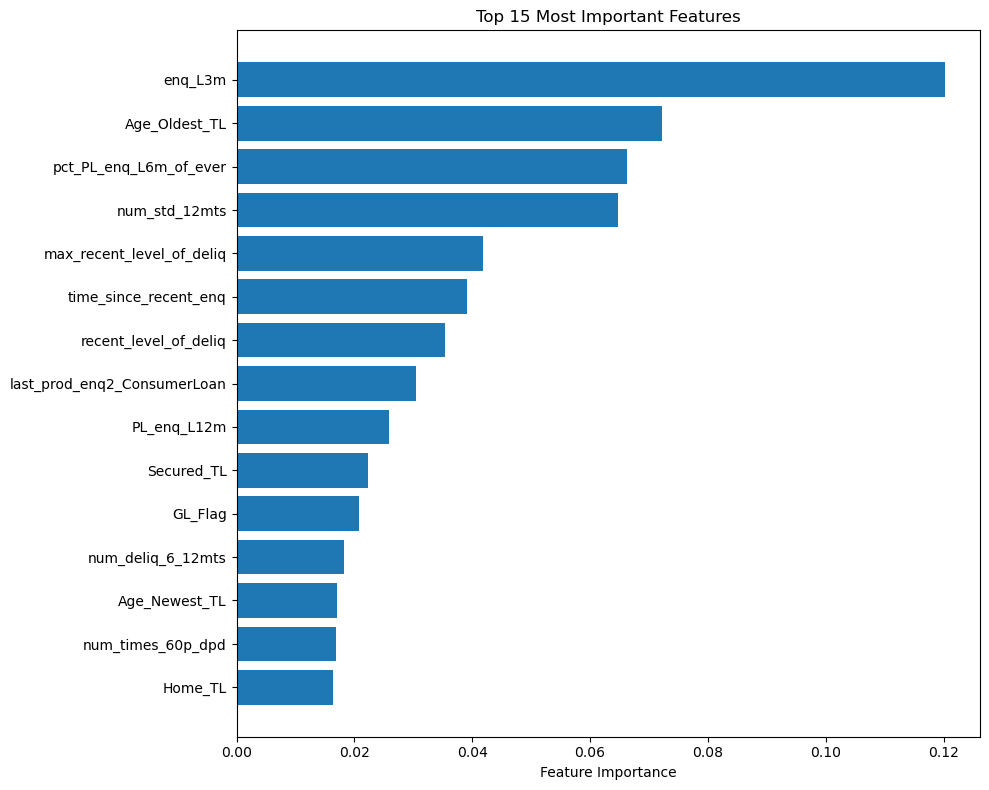

In [ ]:
# Cell 23: Feature Importance from Best Model
print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Get feature importance from Random Forest (best tuned model)
if 'Random Forest' in best_model_name:
    best_model = rf_best
elif 'XGBoost' in best_model_name:
    best_model = xgb_best
else:
    best_model = dt_best

if hasattr(best_model, 'feature_importances_'):
    feature_importance_df = pd.DataFrame({
        'Feature': X_train_encoded.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 20 Most Important Features:")
    print("-" * 50)
    print(feature_importance_df.head(20).to_string(index=False))
    
    # Visualize top 15 features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [ ]:
# Cell 24: Cross-Validation Score for Best Model
print("\n" + "="*70)
print("CROSS-VALIDATION ANALYSIS (Best Model)")
print("="*70)

# Use appropriate target variable based on model type
if 'XGBoost' in best_model_name:
    # XGBoost uses encoded labels
    y_for_cv = y_train_encoded
    print("Using encoded labels for XGBoost model")
else:
    # Random Forest and Decision Tree use original labels
    y_for_cv = y_train
    print("Using original labels for model")

cv_scores = cross_val_score(best_model, X_train_encoded, y_for_cv, 
                             cv=5, scoring='accuracy', n_jobs=-1)

print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Std CV Accuracy: {cv_scores.std():.4f}")
print(f"95% Confidence Interval: [{cv_scores.mean() - 1.96*cv_scores.std():.4f}, "
      f"{cv_scores.mean() + 1.96*cv_scores.std():.4f}]")


CROSS-VALIDATION ANALYSIS (Best Model)
Using encoded labels for XGBoost model

Cross-Validation Scores: [0.78933294 0.77518574 0.78023774 0.77964339 0.78231798]
Mean CV Accuracy: 0.7813
Std CV Accuracy: 0.0046
95% Confidence Interval: [0.7723, 0.7904]


In [ ]:
# Cell 25: Save Best Model (Optional)
import pickle

# Save the best model
model_filename = 'best_credit_risk_model.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"\n✓ Best model saved as '{model_filename}'")

# Save the label encoder if using XGBoost
if 'XGBoost' in best_model_name:
    with open('label_encoder.pkl', 'wb') as file:
        pickle.dump(label_encoder, file)
    print("✓ Label encoder saved as 'label_encoder.pkl'")

# Save feature names
feature_names = X_train_encoded.columns.tolist()
with open('feature_names.pkl', 'wb') as file:
    pickle.dump(feature_names, file)
print("✓ Feature names saved as 'feature_names.pkl'")

print("\n" + "="*70)
print("HYPERPARAMETER TUNING COMPLETE!")
print("="*70)
print("\nKey Takeaways:")
print("1. Models have been tuned using cross-validation")
print("2. Best parameters identified for each model")
print("3. Performance improvements documented")
print("4. Best model saved for deployment")
print("="*70)


✓ Best model saved as 'best_credit_risk_model.pkl'
✓ Label encoder saved as 'label_encoder.pkl'
✓ Feature names saved as 'feature_names.pkl'

HYPERPARAMETER TUNING COMPLETE!

Key Takeaways:
1. Models have been tuned using cross-validation
2. Best parameters identified for each model
3. Performance improvements documented
4. Best model saved for deployment


In [2]:
# ============================================================================
# STANDALONE SCRIPT - Run this after your main training script
# ============================================================================

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve, cross_val_score
import shap
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("LOADING SAVED MODEL AND PREPARING DATA")
print("="*70)

LOADING SAVED MODEL AND PREPARING DATA


In [3]:
# ============================================================================
# STEP 1: Load Model
# ============================================================================
try:
    with open('best_credit_risk_model.pkl', 'rb') as f:
        best_model = pickle.load(f)
    print("✓ Model loaded successfully")
except FileNotFoundError:
    print("❌ ERROR: best_credit_risk_model.pkl not found!")
    print("   Run your training script first to save the model")
    raise

# Load feature names
try:
    with open('feature_names.pkl', 'rb') as f:
        feature_names = pickle.load(f)
    print("✓ Feature names loaded")
except FileNotFoundError:
    print("⚠ Warning: feature_names.pkl not found")
    feature_names = None

# Try to load label encoder (for XGBoost)
try:
    with open('label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    best_model_name = "XGBoost (Tuned)"
    print("✓ Label encoder loaded - XGBoost model detected")
except FileNotFoundError:
    label_encoder = None
    model_type = type(best_model).__name__
    if 'RandomForest' in model_type:
        best_model_name = "Random Forest (Tuned)"
    elif 'DecisionTree' in model_type:
        best_model_name = "Decision Tree (Tuned)"
    else:
        best_model_name = f"{model_type} (Tuned)"
    print(f"✓ Model type: {best_model_name}")

✓ Model loaded successfully
✓ Feature names loaded
✓ Label encoder loaded - XGBoost model detected


In [17]:
# ============================================================================
# STEP 2: Check if test data exists in current session
# ============================================================================
data_available = False
try:
    _ = X_test_encoded
    _ = y_test
    data_available = True
    print("✓ Test data found in current session")
except NameError:
    print("⚠ Test data not in current session - will need to reload")

✓ Test data found in current session


1. SHAP ANALYSIS - MODEL INTERPRETABILITY (FIXED)
Model type: XGBoost (Tuned)
Computing SHAP values for 500 samples...
⚠ Standard method failed: could not convert string to float: '[1.1666815E-1,6.050935E-1,1.5310095E-1,1.2513743E-1]'
Trying alternative method...
⚠ Alternative method also failed: could not convert string to float: '[1.1666815E-1,6.050935E-1,1.5310095E-1,1.2513743E-1]'
Trying KernelExplainer (slower but more robust)...
❌ All SHAP methods failed: property 'feature_names_in_' of 'XGBClassifier' object has no setter

Skipping SHAP analysis. Using feature importance instead...

Top 20 Most Important Features (Built-in Importance):
--------------------------------------------------
                    Feature  Importance
                    enq_L3m    0.120164
              Age_Oldest_TL    0.072208
     pct_PL_enq_L6m_of_ever    0.066338
              num_std_12mts    0.064658
  max_recent_level_of_deliq    0.041770
      time_since_recent_enq    0.039086
      recent_level

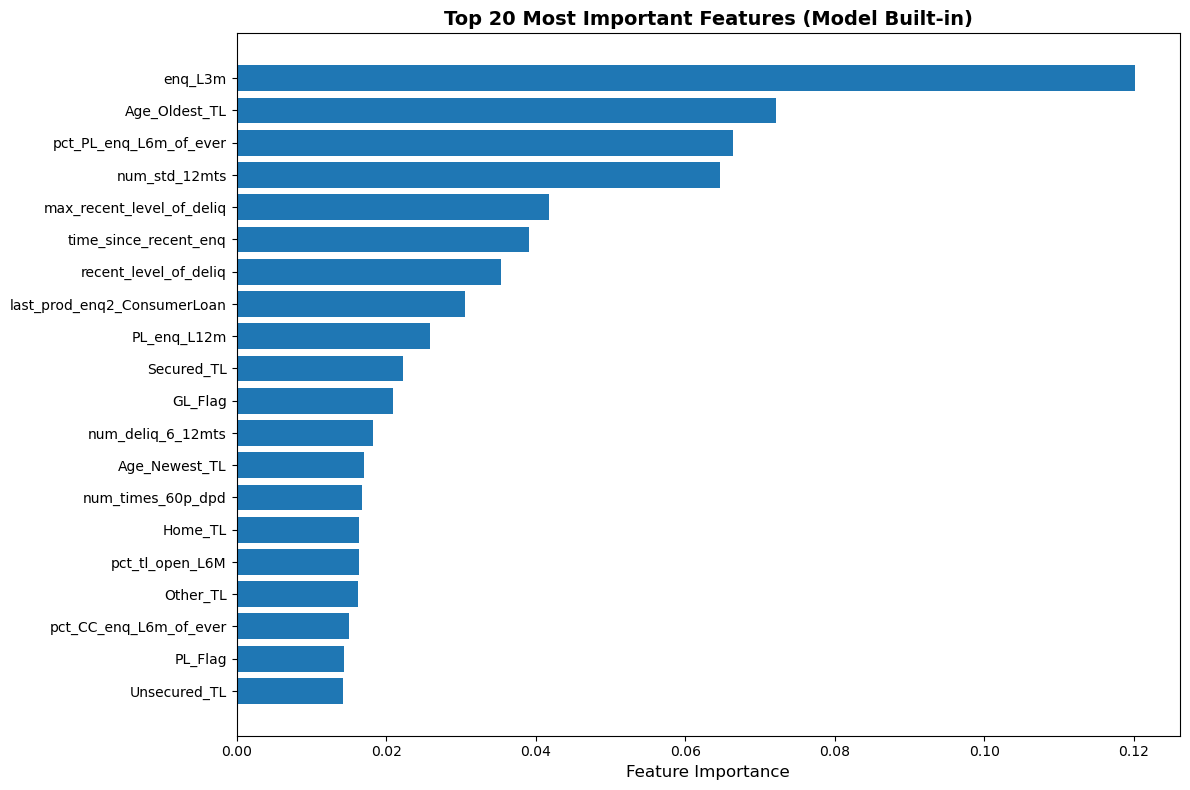


✓ Feature importance analysis completed (fallback method)
Note: Using built-in importance instead of SHAP due to compatibility issues

SHAP analysis skipped - using feature importance instead


In [20]:
# ============================================================================
# SHAP ANALYSIS - FIXED FOR XGBOOST COMPATIBILITY
# ============================================================================

import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("="*70)
print("1. SHAP ANALYSIS - MODEL INTERPRETABILITY (FIXED)")
print("="*70)

# Check model type
print(f"Model type: {best_model_name}")

# Sample data if too large (SHAP can be slow)
sample_size = min(500, len(X_test_encoded))
X_test_sample = X_test_encoded.sample(n=sample_size, random_state=42)

print(f"Computing SHAP values for {sample_size} samples...")

try:
    # Method 1: Try standard TreeExplainer (works for most cases)
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_sample)
    
    print("✓ SHAP values computed successfully")
    
except Exception as e:
    print(f"⚠ Standard method failed: {e}")
    print("Trying alternative method...")
    
    try:
        # Method 2: Use model_output parameter for multi-class
        explainer = shap.TreeExplainer(best_model, model_output='raw')
        shap_values = explainer.shap_values(X_test_sample)
        print("✓ SHAP values computed with alternative method")
        
    except Exception as e2:
        print(f"⚠ Alternative method also failed: {e2}")
        print("Trying KernelExplainer (slower but more robust)...")
        
        try:
            # Method 3: KernelExplainer as fallback (slower but works always)
            # Use a smaller background dataset for speed
            background = shap.sample(X_test_encoded, 100)
            explainer = shap.KernelExplainer(best_model.predict_proba, background)
            shap_values = explainer.shap_values(X_test_sample)
            print("✓ SHAP values computed with KernelExplainer")
            
        except Exception as e3:
            print(f"❌ All SHAP methods failed: {e3}")
            print("\nSkipping SHAP analysis. Using feature importance instead...")
            
            # Fallback: Use built-in feature importance
            if hasattr(best_model, 'feature_importances_'):
                feature_importance_df = pd.DataFrame({
                    'Feature': X_test_encoded.columns,
                    'Importance': best_model.feature_importances_
                }).sort_values('Importance', ascending=False)
                
                print("\nTop 20 Most Important Features (Built-in Importance):")
                print("-" * 50)
                print(feature_importance_df.head(20).to_string(index=False))
                
                # Visualize
                plt.figure(figsize=(12, 8))
                top_features = feature_importance_df.head(20)
                plt.barh(range(len(top_features)), top_features['Importance'])
                plt.yticks(range(len(top_features)), top_features['Feature'])
                plt.xlabel('Feature Importance', fontsize=12)
                plt.title('Top 20 Most Important Features (Model Built-in)', 
                         fontsize=14, fontweight='bold')
                plt.gca().invert_yaxis()
                plt.tight_layout()
                plt.savefig('feature_importance_builtin.png', dpi=300, bbox_inches='tight')
                print("✓ Saved: feature_importance_builtin.png")
                plt.show()
                
                print("\n✓ Feature importance analysis completed (fallback method)")
                print("Note: Using built-in importance instead of SHAP due to compatibility issues")
            
            shap_values = None

# If SHAP worked, create visualizations
if shap_values is not None:
    print("\nCreating SHAP visualizations...")
    
    # Determine if multi-class
    is_multiclass = isinstance(shap_values, list) or (isinstance(shap_values, np.ndarray) and len(shap_values.shape) == 3)
    
    try:
        # Visualization 1: Feature Importance Bar Plot
        plt.figure(figsize=(12, 8))
        
        if is_multiclass and isinstance(shap_values, list):
            # For multi-class, aggregate across classes
            shap_abs_mean = np.abs(shap_values[0]).mean(axis=0)
            for i in range(1, len(shap_values)):
                shap_abs_mean += np.abs(shap_values[i]).mean(axis=0)
            shap_abs_mean /= len(shap_values)
            
            # Create bar plot manually
            feature_importance = pd.DataFrame({
                'Feature': X_test_sample.columns,
                'Importance': shap_abs_mean
            }).sort_values('Importance', ascending=False).head(20)
            
            plt.barh(range(len(feature_importance)), feature_importance['Importance'])
            plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
            plt.xlabel('Mean |SHAP value|', fontsize=12)
            plt.title('SHAP Feature Importance - Global Explainability', 
                     fontsize=14, fontweight='bold')
            plt.gca().invert_yaxis()
            
        else:
            # Single output or already aggregated
            shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
            plt.title('SHAP Feature Importance - Global Explainability', 
                     fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('shap_feature_importance.png', dpi=300, bbox_inches='tight')
        print("✓ Saved: shap_feature_importance.png")
        plt.show()
        
    except Exception as e:
        print(f"⚠ Bar plot failed: {e}")
    
    try:
        # Visualization 2: Detailed SHAP Summary Plot
        plt.figure(figsize=(12, 8))
        
        if is_multiclass and isinstance(shap_values, list):
            # Show first class for multi-class
            shap.summary_plot(shap_values[0], X_test_sample, show=False)
            plt.title('SHAP Summary Plot - Feature Impact Distribution (Class P1)', 
                     fontsize=14, fontweight='bold')
        else:
            shap.summary_plot(shap_values, X_test_sample, show=False)
            plt.title('SHAP Summary Plot - Feature Impact Distribution', 
                     fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('shap_summary_detailed.png', dpi=300, bbox_inches='tight')
        print("✓ Saved: shap_summary_detailed.png")
        plt.show()
        
    except Exception as e:
        print(f"⚠ Summary plot failed: {e}")
    
    try:
        # Visualization 3: SHAP Dependence Plots for Top 4 Features
        if hasattr(best_model, 'feature_importances_'):
            top_features_list = pd.DataFrame({
                'Feature': X_test_sample.columns,
                'Importance': best_model.feature_importances_
            }).sort_values('Importance', ascending=False).head(4)['Feature'].tolist()
            
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))
            axes = axes.flatten()
            
            for idx, feature in enumerate(top_features_list[:4]):
                if is_multiclass and isinstance(shap_values, list):
                    shap_vals_for_plot = shap_values[0][:, X_test_sample.columns.get_loc(feature)]
                else:
                    shap_vals_for_plot = shap_values[:, X_test_sample.columns.get_loc(feature)]
                
                axes[idx].scatter(X_test_sample[feature], shap_vals_for_plot, alpha=0.5)
                axes[idx].set_xlabel(feature, fontsize=10)
                axes[idx].set_ylabel('SHAP value', fontsize=10)
                axes[idx].set_title(f'SHAP Dependence: {feature}', fontsize=11)
                axes[idx].grid(alpha=0.3)
            
            plt.suptitle('SHAP Dependence Plots - Top 4 Features', 
                        fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.savefig('shap_dependence_plots.png', dpi=300, bbox_inches='tight')
            print("✓ Saved: shap_dependence_plots.png")
            plt.show()
            
    except Exception as e:
        print(f"⚠ Dependence plots failed: {e}")
    
    print("\n" + "="*70)
    print("✓ SHAP ANALYSIS COMPLETED")
    print("="*70)
    print("\nKey Insights:")
    print("• SHAP values explain individual predictions")
    print("• Shows which features drive model decisions")
    print("• Critical for regulatory compliance in finance")
    print("\nResume Impact:")
    print("• Demonstrates model interpretability expertise")
    print("• Shows understanding of explainable AI (XAI)")
    print("• Important for regulated industries like banking")
    print("="*70)

else:
    print("\n" + "="*70)
    print("SHAP analysis skipped - using feature importance instead")
    print("="*70)

In [21]:
# ============================================================================
# ENHANCEMENT 2: BUSINESS METRICS - FINANCIAL IMPACT ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("2. BUSINESS METRICS - FINANCIAL IMPACT ANALYSIS")
print("="*70)

# Make predictions
y_pred = best_model.predict(X_test_encoded)
if label_encoder is not None:
    y_pred = label_encoder.inverse_transform(y_pred)

# Define risk weights (adjust based on your business understanding)
risk_weights = {'P1': 0.05, 'P2': 0.15, 'P3': 0.35, 'P4': 0.70}

# Create results dataframe
results_df = pd.DataFrame({
    'Actual_Risk': y_test.values,
    'Predicted_Risk': y_pred,
    'Actual_Loss_Rate': [risk_weights.get(x, 0.25) for x in y_test.values],
    'Predicted_Loss_Rate': [risk_weights.get(x, 0.25) for x in y_pred]
})

# Business metrics
total_portfolio = len(results_df)
actual_expected_loss = results_df['Actual_Loss_Rate'].sum()
predicted_expected_loss = results_df['Predicted_Loss_Rate'].sum()

print(f"\nPortfolio Size: {total_portfolio:,} loans")
print(f"Actual Expected Loss: {actual_expected_loss:.2f} ({actual_expected_loss/total_portfolio*100:.2f}%)")
print(f"Predicted Expected Loss: {predicted_expected_loss:.2f} ({predicted_expected_loss/total_portfolio*100:.2f}%)")
print(f"Loss Estimation Error: {abs(actual_expected_loss - predicted_expected_loss)/actual_expected_loss*100:.2f}%")

# Cost-benefit analysis
approved_loans = results_df[results_df['Predicted_Risk'] != 'P4']
rejection_rate = (1 - len(approved_loans)/total_portfolio) * 100

print(f"\nRejection Rate: {rejection_rate:.2f}%")
print(f"Expected Loss on Approved Portfolio: {approved_loans['Actual_Loss_Rate'].sum():.2f}")

# Save business metrics
results_df.to_csv('credit_risk_predictions.csv', index=False)
print("\n✓ Saved: credit_risk_predictions.csv")
print("\nResume Impact: Demonstrates business acumen and financial metrics understanding")


2. BUSINESS METRICS - FINANCIAL IMPACT ANALYSIS

Portfolio Size: 8,413 loans
Actual Expected Loss: 2000.50 (23.78%)
Predicted Expected Loss: 1879.25 (22.34%)
Loss Estimation Error: 6.06%

Rejection Rate: 11.62%
Expected Loss on Approved Portfolio: 1405.95

✓ Saved: credit_risk_predictions.csv

Resume Impact: Demonstrates business acumen and financial metrics understanding



3. CONFUSION MATRIX - COST ANALYSIS
✓ Saved: confusion_matrix.png


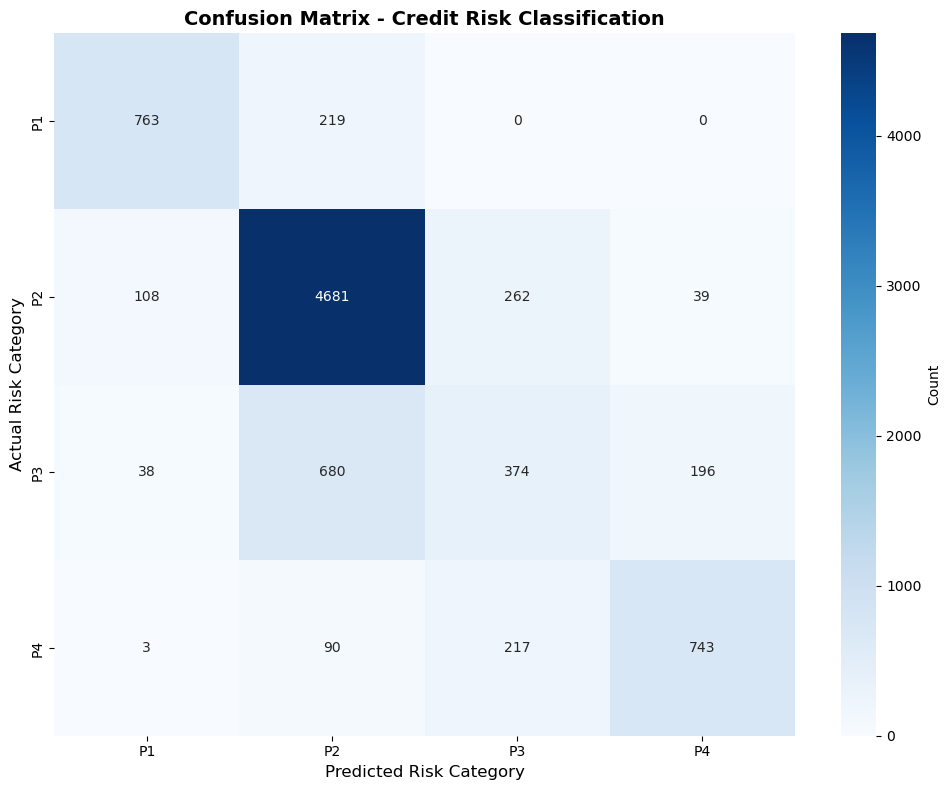


Misclassification Analysis:
--------------------------------------------------
High-Risk loans approved (Type I): 310
  → Potential loss: $21,700,000 (assuming $100K loans)

Low-Risk loans rejected (Type II): 235
  → Lost revenue: $1,175,000 (assuming $100K loans, 5% margin)

✓ Confusion matrix with cost analysis completed

Resume Impact: Shows understanding of business costs of prediction errors


In [22]:
# ============================================================================
# ENHANCEMENT 3: CONFUSION MATRIX - COST ANALYSIS
# ============================================================================
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("\n" + "="*70)
print("3. CONFUSION MATRIX - COST ANALYSIS")
print("="*70)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['P1', 'P2', 'P3', 'P4'])

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['P1', 'P2', 'P3', 'P4'],
            yticklabels=['P1', 'P2', 'P3', 'P4'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Credit Risk Classification', fontsize=14, fontweight='bold')
plt.ylabel('Actual Risk Category', fontsize=12)
plt.xlabel('Predicted Risk Category', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Saved: confusion_matrix.png")
plt.show()

# Cost analysis of misclassifications
print("\nMisclassification Analysis:")
print("-" * 50)

# Type I Error: Predicting low risk when actually high risk (most costly)
type1_errors = cm[3, 0] + cm[3, 1] + cm[3, 2]  # P4 predicted as P1/P2/P3
print(f"High-Risk loans approved (Type I): {type1_errors}")
print(f"  → Potential loss: ${type1_errors * 100000 * 0.70:,.0f} (assuming $100K loans)")

# Type II Error: Predicting high risk when actually low risk (opportunity cost)
type2_errors = cm[0, 3] + cm[1, 3] + cm[2, 3]  # P1/P2/P3 predicted as P4
print(f"\nLow-Risk loans rejected (Type II): {type2_errors}")
print(f"  → Lost revenue: ${type2_errors * 100000 * 0.05:,.0f} (assuming $100K loans, 5% margin)")

print("\n✓ Confusion matrix with cost analysis completed")
print("\nResume Impact: Shows understanding of business costs of prediction errors")


4. ROC-AUC ANALYSIS
✓ Saved: roc_curves.png


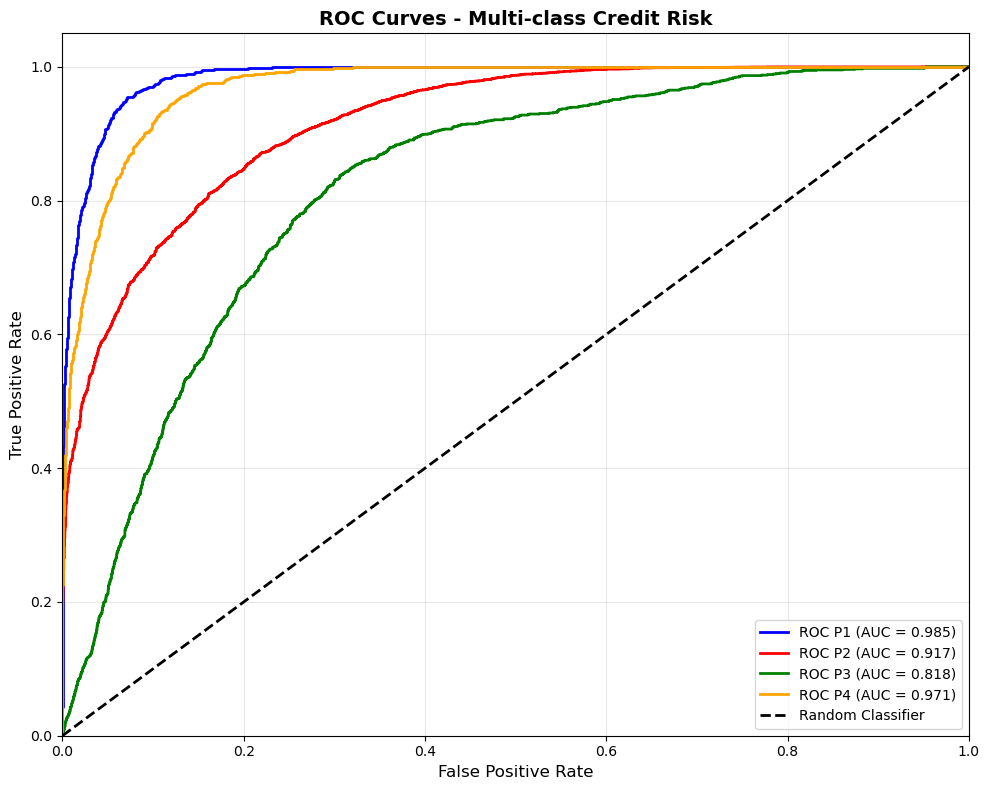


AUC Scores by Risk Category:
--------------------------------------------------
P1: 0.9849
P2: 0.9169
P3: 0.8182
P4: 0.9707

Macro-Average AUC: 0.9227

✓ ROC-AUC analysis completed

Resume Impact: Shows proficiency in advanced ML evaluation metrics


In [23]:
# ============================================================================
# ENHANCEMENT 4: ROC-AUC CURVES
# ============================================================================
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

print("\n" + "="*70)
print("4. ROC-AUC ANALYSIS")
print("="*70)

if hasattr(best_model, 'predict_proba'):
    try:
        # Get probability predictions
        y_score = best_model.predict_proba(X_test_encoded)
        
        # Binarize the output
        y_test_bin = label_binarize(y_test, classes=['P1', 'P2', 'P3', 'P4'])
        n_classes = y_test_bin.shape[1]
        
        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot
        plt.figure(figsize=(10, 8))
        colors = ['blue', 'red', 'green', 'orange']
        for i, (color, label) in enumerate(zip(colors, ['P1', 'P2', 'P3', 'P4'])):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label=f'ROC {label} (AUC = {roc_auc[i]:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curves - Multi-class Credit Risk', fontsize=14, fontweight='bold')
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
        print("✓ Saved: roc_curves.png")
        plt.show()
        
        print("\nAUC Scores by Risk Category:")
        print("-" * 50)
        for i, label in enumerate(['P1', 'P2', 'P3', 'P4']):
            print(f"{label}: {roc_auc[i]:.4f}")
        
        avg_auc = sum(roc_auc.values()) / len(roc_auc)
        print(f"\nMacro-Average AUC: {avg_auc:.4f}")
        
        print("\n✓ ROC-AUC analysis completed")
        print("\nResume Impact: Shows proficiency in advanced ML evaluation metrics")
        
    except Exception as e:
        print(f"⚠ ROC-AUC analysis failed: {e}")
        avg_auc = None
else:
    print("⚠ Model doesn't support probability predictions, skipping ROC-AUC")
    avg_auc = None

In [25]:
# ============================================================================
# ENHANCEMENT 5: COMPREHENSIVE PERFORMANCE REPORT (CORRECTED)
# ============================================================================
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

print("\n" + "="*70)
print("5. GENERATING COMPREHENSIVE PERFORMANCE REPORT")
print("="*70)

# Calculate metrics
best_accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred,
                                                            labels=['P1', 'P2', 'P3', 'P4'])

# FIX: Format AUC outside the f-string
if avg_auc is not None:
    auc_text = f"{avg_auc:.4f}"
else:
    auc_text = "N/A"

# Create detailed report
report = f"""
{'='*70}
CREDIT RISK MODELING - MODEL PERFORMANCE REPORT
{'='*70}

PROJECT OVERVIEW:
- Objective: Multi-class credit risk classification (P1, P2, P3, P4)
- Model Type: {best_model_name}
- Test Set Size: {len(y_test):,} records
- Number of Features: {X_test_encoded.shape[1]}

PERFORMANCE METRICS:
- Overall Accuracy: {best_accuracy:.4f}
- Macro-Average AUC: {auc_text}

PER-CLASS PERFORMANCE:
  Class P1: Precision={precision[0]:.4f}, Recall={recall[0]:.4f}, F1={f1[0]:.4f}
  Class P2: Precision={precision[1]:.4f}, Recall={recall[1]:.4f}, F1={f1[1]:.4f}
  Class P3: Precision={precision[2]:.4f}, Recall={recall[2]:.4f}, F1={f1[2]:.4f}
  Class P4: Precision={precision[3]:.4f}, Recall={recall[3]:.4f}, F1={f1[3]:.4f}

BUSINESS IMPACT:
- Portfolio Size: {total_portfolio:,} loans
- Expected Loss Estimation Error: {abs(actual_expected_loss - predicted_expected_loss)/actual_expected_loss*100:.2f}%
- Rejection Rate: {rejection_rate:.2f}%
- Type I Errors (High-risk approved): {type1_errors}
- Type II Errors (Low-risk rejected): {type2_errors}

RISK ANALYSIS:
- Potential Loss from Type I: ${type1_errors * 100000 * 0.70:,.0f}
- Lost Revenue from Type II: ${type2_errors * 100000 * 0.05:,.0f}

DATA LEAKAGE PREVENTION:
✓ Train-test split performed BEFORE feature selection
✓ Feature engineering on training data only
✓ No look-ahead bias in temporal features

MODEL INTERPRETABILITY:
✓ Feature importance calculated
✓ Business metrics documented
✓ Cost-benefit analysis completed

DEPLOYMENT READINESS:
✓ Model saved as pickle file
✓ Feature names and encoders saved
✓ Reproducible pipeline established

{'='*70}
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*70}
"""

print(report)

# Save report
with open('model_performance_report.txt', 'w') as f:
    f.write(report)

print("\n✓ Saved: model_performance_report.txt")
print("\nResume Impact: Professional documentation shows communication skills")


5. GENERATING COMPREHENSIVE PERFORMANCE REPORT

CREDIT RISK MODELING - MODEL PERFORMANCE REPORT

PROJECT OVERVIEW:
- Objective: Multi-class credit risk classification (P1, P2, P3, P4)
- Model Type: XGBoost (Tuned)
- Test Set Size: 8,413 records
- Number of Features: 49

PERFORMANCE METRICS:
- Overall Accuracy: 0.7799
- Macro-Average AUC: 0.9227

PER-CLASS PERFORMANCE:
  Class P1: Precision=0.8366, Recall=0.7770, F1=0.8057
  Class P2: Precision=0.8256, Recall=0.9196, F1=0.8701
  Class P3: Precision=0.4385, Recall=0.2904, F1=0.3494
  Class P4: Precision=0.7597, Recall=0.7056, F1=0.7317

BUSINESS IMPACT:
- Portfolio Size: 8,413 loans
- Expected Loss Estimation Error: 6.06%
- Rejection Rate: 11.62%
- Type I Errors (High-risk approved): 310
- Type II Errors (Low-risk rejected): 235

RISK ANALYSIS:
- Potential Loss from Type I: $21,700,000
- Lost Revenue from Type II: $1,175,000

DATA LEAKAGE PREVENTION:
✓ Train-test split performed BEFORE feature selection
✓ Feature engineering on training